# Mohamed Tarek

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.callbacks import  ModelCheckpoint ,ReduceLROnPlateau ,EarlyStopping
import numpy as np0
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from Evaluation_matrices import f1
tf.config.run_functions_eagerly(True)

# Data Preprocessing

In [2]:
data_dir = r'E:\NU\color identification\train'

images = []
labels = []

for color in os.listdir(data_dir):
    color_path = os.path.join(data_dir, color)
    if os.path.isdir(color_path):
        for filename in os.listdir(color_path):
            img_path = os.path.join(color_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (64, 64))  # Resize for consistency
            images.append(img)
            labels.append(color)

images = np.array(images)
labels = np.array(labels)


# Make labels one hot for model

In [3]:
# Create a mapping from unique labels to indices
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}

# Encode the original labels into numerical indices using the mapping
labels_encoded = np.array([label_mapping[label] for label in labels])

# Convert the encoded labels into one-hot encoded format
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded)


# Split data for training and validation 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

In [5]:
print("Total number of data",len(images))
print("Total number of training data",len(X_train))
print("Total number of testing data",len(X_test))


Total number of data 6239
Total number of training data 4991
Total number of testing data 1248


# Normalize Data 

In [6]:
X_train = X_train / 255.0
X_test  = X_test / 255.0

# Data Augmentation

In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images in the range [-20 degrees, +20 degrees]
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,           # Apply shear transformation with a shear intensity of up to 20%
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True       # Randomly flip images horizontally
)

datagen.fit(X_train)  # Fit the data generator to the training data


# Model Architecture

In [8]:
model = models.Sequential()

# Input normalization
model.add(layers.BatchNormalization(input_shape=(64, 64, 3)))

# Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer with softmax activation for color classes
model.add(layers.Dense(len(label_mapping), activation='softmax'))



# Metrics And Callbacks

In [9]:
checkpoint = ModelCheckpoint(r'E:\NU\color identification\model\model', verbose=1, monitor ='val_loss',  save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [ checkpoint, reduce_lr,early_stop ]

opt = tf.keras.optimizers.experimental.Adam(1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc',f1])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 64, 64, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       1

# Training 

In [10]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test) ,epochs=100 , steps_per_epoch= len(X_train) // 32 , callbacks=callbacks)
model.save_weights(r'E:\NU\color identification\model\model')
model.save(r'E:\NU\color identification\model\model\myodel.h5')

Epoch 1/100


C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


155/155 [==============================] - ETA: 0s - loss: 2.0582 - acc: 0.2728 - f1: 0.1253
Epoch 1: val_loss improved from inf to 2.08804, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 19s 103ms/step - loss: 2.0582 - acc: 0.2728 - f1: 0.1253 - val_loss: 2.0880 - val_acc: 0.2700 - val_f1: 0.1716 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - ETA: 0s - loss: 1.7888 - acc: 0.3543 - f1: 0.2190
Epoch 2: val_loss improved from 2.08804 to 1.71478, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 16s 101ms/step - loss: 1.7888 - acc: 0.3543 - f1: 0.2190 - val_loss: 1.7148 - val_acc: 0.3670 - val_f1: 0.2344 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - ETA: 0s - loss: 1.7203 - acc: 0.3825 - f1: 0.2333
Epoch 3: val_loss improved from 1.71478 to 1.60212, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 98ms/step - loss: 1.7203 - acc: 0.3825 - f1: 0.2333 - val_loss: 1.6021 - val_acc: 0.4311 - val_f1: 0.2255 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - ETA: 0s - loss: 1.6434 - acc: 0.4140 - f1: 0.2725
Epoch 4: val_loss improved from 1.60212 to 1.49530, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 99ms/step - loss: 1.6434 - acc: 0.4140 - f1: 0.2725 - val_loss: 1.4953 - val_acc: 0.4688 - val_f1: 0.3624 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - ETA: 0s - loss: 1.6192 - acc: 0.4251 - f1: 0.2835
Epoch 5: val_loss improved from 1.49530 to 1.48817, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 94ms/step - loss: 1.6192 - acc: 0.4251 - f1: 0.2835 - val_loss: 1.4882 - val_acc: 0.5032 - val_f1: 0.2966 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - ETA: 0s - loss: 1.5958 - acc: 0.4489 - f1: 0.3065
Epoch 6: val_loss improved from 1.48817 to 1.45721, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 16s 103ms/step - loss: 1.5958 - acc: 0.4489 - f1: 0.3065 - val_loss: 1.4572 - val_acc: 0.4960 - val_f1: 0.4189 - lr: 0.0010
Epoch 7/100
155/155 [==============================] - ETA: 0s - loss: 1.5763 - acc: 0.4630 - f1: 0.3390
Epoch 7: val_loss did not improve from 1.45721
155/155 [==============================] - 13s 85ms/step - loss: 1.5763 - acc: 0.4630 - f1: 0.3390 - val_loss: 1.4761 - val_acc: 0.4992 - val_f1: 0.3280 - lr: 0.0010
Epoch 8/100
155/155 [==============================] - ETA: 0s - loss: 1.5020 - acc: 0.5064 - f1: 0.3907
Epoch 8: val_loss improved from 1.45721 to 1.43582, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 94ms/step - loss: 1.5020 - acc: 0.5064 - f1: 0.3907 - val_loss: 1.4358 - val_acc: 0.5232 - val_f1: 0.4446 - lr: 0.0010
Epoch 9/100
155/155 [==============================] - ETA: 0s - loss: 1.4674 - acc: 0.5174 - f1: 0.4199
Epoch 9: val_loss improved from 1.43582 to 1.38343, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 96ms/step - loss: 1.4674 - acc: 0.5174 - f1: 0.4199 - val_loss: 1.3834 - val_acc: 0.5449 - val_f1: 0.4708 - lr: 0.0010
Epoch 10/100
155/155 [==============================] - ETA: 0s - loss: 1.4477 - acc: 0.5227 - f1: 0.4250
Epoch 10: val_loss did not improve from 1.38343
155/155 [==============================] - 13s 84ms/step - loss: 1.4477 - acc: 0.5227 - f1: 0.4250 - val_loss: 1.5421 - val_acc: 0.5337 - val_f1: 0.4517 - lr: 0.0010
Epoch 11/100
155/155 [==============================] - ETA: 0s - loss: 1.4642 - acc: 0.5197 - f1: 0.4258
Epoch 11: val_loss did not improve from 1.38343
155/155 [==============================] - 13s 84ms/step - loss: 1.4642 - acc: 0.5197 - f1: 0.4258 - val_loss: 1.3942 - val_acc: 0.5417 - val_f1: 0.4150 - lr: 0.0010
Epoch 12/100
155/155 [==============================] - ETA: 0s - loss: 1.3943 - acc: 0.5398 - f1: 0.4564
Epoch 12: val_loss improved from 1.38343 to 1.24525, saving model to E:\NU\color identif

INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 95ms/step - loss: 1.3943 - acc: 0.5398 - f1: 0.4564 - val_loss: 1.2452 - val_acc: 0.5986 - val_f1: 0.5347 - lr: 0.0010
Epoch 13/100
155/155 [==============================] - ETA: 0s - loss: 1.3852 - acc: 0.5459 - f1: 0.4662
Epoch 13: val_loss did not improve from 1.24525
155/155 [==============================] - 12s 80ms/step - loss: 1.3852 - acc: 0.5459 - f1: 0.4662 - val_loss: 1.2934 - val_acc: 0.5849 - val_f1: 0.4521 - lr: 0.0010
Epoch 14/100
155/155 [==============================] - ETA: 0s - loss: 1.3552 - acc: 0.5537 - f1: 0.4730
Epoch 14: val_loss improved from 1.24525 to 1.21898, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 16s 101ms/step - loss: 1.3552 - acc: 0.5537 - f1: 0.4730 - val_loss: 1.2190 - val_acc: 0.5986 - val_f1: 0.5420 - lr: 0.0010
Epoch 15/100
155/155 [==============================] - ETA: 0s - loss: 1.3158 - acc: 0.5642 - f1: 0.4943
Epoch 15: val_loss did not improve from 1.21898
155/155 [==============================] - 13s 84ms/step - loss: 1.3158 - acc: 0.5642 - f1: 0.4943 - val_loss: 1.2767 - val_acc: 0.5817 - val_f1: 0.5220 - lr: 0.0010
Epoch 16/100
155/155 [==============================] - ETA: 0s - loss: 1.3631 - acc: 0.5465 - f1: 0.4775
Epoch 16: val_loss did not improve from 1.21898
155/155 [==============================] - 12s 79ms/step - loss: 1.3631 - acc: 0.5465 - f1: 0.4775 - val_loss: 1.3909 - val_acc: 0.5304 - val_f1: 0.4829 - lr: 0.0010
Epoch 17/100
155/155 [==============================] - ETA: 0s - loss: 1.3347 - acc: 0.5578 - f1: 0.4932
Epoch 17: val_loss improved from 1.21898 to 1.20951, saving model to E:\NU\color identi

INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 96ms/step - loss: 1.3347 - acc: 0.5578 - f1: 0.4932 - val_loss: 1.2095 - val_acc: 0.6170 - val_f1: 0.5491 - lr: 0.0010
Epoch 18/100
155/155 [==============================] - ETA: 0s - loss: 1.3116 - acc: 0.5658 - f1: 0.4958
Epoch 18: val_loss did not improve from 1.20951
155/155 [==============================] - 13s 86ms/step - loss: 1.3116 - acc: 0.5658 - f1: 0.4958 - val_loss: 1.2308 - val_acc: 0.6074 - val_f1: 0.5418 - lr: 0.0010
Epoch 19/100
155/155 [==============================] - ETA: 0s - loss: 1.2925 - acc: 0.5721 - f1: 0.5008
Epoch 19: val_loss improved from 1.20951 to 1.15852, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 99ms/step - loss: 1.2925 - acc: 0.5721 - f1: 0.5008 - val_loss: 1.1585 - val_acc: 0.6410 - val_f1: 0.5815 - lr: 0.0010
Epoch 20/100
155/155 [==============================] - ETA: 0s - loss: 1.3550 - acc: 0.5529 - f1: 0.4818
Epoch 20: val_loss did not improve from 1.15852
155/155 [==============================] - 12s 80ms/step - loss: 1.3550 - acc: 0.5529 - f1: 0.4818 - val_loss: 1.2342 - val_acc: 0.5946 - val_f1: 0.5154 - lr: 0.0010
Epoch 21/100
155/155 [==============================] - ETA: 0s - loss: 1.3238 - acc: 0.5622 - f1: 0.4923
Epoch 21: val_loss did not improve from 1.15852
155/155 [==============================] - 13s 84ms/step - loss: 1.3238 - acc: 0.5622 - f1: 0.4923 - val_loss: 1.2028 - val_acc: 0.6138 - val_f1: 0.5465 - lr: 0.0010
Epoch 22/100
155/155 [==============================] - ETA: 0s - loss: 1.2857 - acc: 0.5773 - f1: 0.5075
Epoch 22: val_loss did not improve from 1.15852

Epoch 22: ReduceLROnPlateau reducing le

INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 14s 93ms/step - loss: 1.1725 - acc: 0.6076 - f1: 0.5620 - val_loss: 1.0792 - val_acc: 0.6410 - val_f1: 0.5953 - lr: 1.0000e-04
Epoch 24/100
155/155 [==============================] - ETA: 0s - loss: 1.1151 - acc: 0.6320 - f1: 0.5908
Epoch 24: val_loss improved from 1.07925 to 1.06928, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 95ms/step - loss: 1.1151 - acc: 0.6320 - f1: 0.5908 - val_loss: 1.0693 - val_acc: 0.6450 - val_f1: 0.6151 - lr: 1.0000e-04
Epoch 25/100
155/155 [==============================] - ETA: 0s - loss: 1.1317 - acc: 0.6286 - f1: 0.5915
Epoch 25: val_loss did not improve from 1.06928
155/155 [==============================] - 13s 84ms/step - loss: 1.1317 - acc: 0.6286 - f1: 0.5915 - val_loss: 1.0842 - val_acc: 0.6482 - val_f1: 0.6091 - lr: 1.0000e-04
Epoch 26/100
155/155 [==============================] - ETA: 0s - loss: 1.0909 - acc: 0.6431 - f1: 0.5998
Epoch 26: val_loss improved from 1.06928 to 1.05666, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 99ms/step - loss: 1.0909 - acc: 0.6431 - f1: 0.5998 - val_loss: 1.0567 - val_acc: 0.6458 - val_f1: 0.6236 - lr: 1.0000e-04
Epoch 27/100
155/155 [==============================] - ETA: 0s - loss: 1.0869 - acc: 0.6396 - f1: 0.6038
Epoch 27: val_loss improved from 1.05666 to 1.05033, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 96ms/step - loss: 1.0869 - acc: 0.6396 - f1: 0.6038 - val_loss: 1.0503 - val_acc: 0.6611 - val_f1: 0.6238 - lr: 1.0000e-04
Epoch 28/100
155/155 [==============================] - ETA: 0s - loss: 1.0878 - acc: 0.6427 - f1: 0.6073
Epoch 28: val_loss did not improve from 1.05033
155/155 [==============================] - 12s 79ms/step - loss: 1.0878 - acc: 0.6427 - f1: 0.6073 - val_loss: 1.0540 - val_acc: 0.6330 - val_f1: 0.6302 - lr: 1.0000e-04
Epoch 29/100
155/155 [==============================] - ETA: 0s - loss: 1.0780 - acc: 0.6473 - f1: 0.6108
Epoch 29: val_loss improved from 1.05033 to 1.04192, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 98ms/step - loss: 1.0780 - acc: 0.6473 - f1: 0.6108 - val_loss: 1.0419 - val_acc: 0.6458 - val_f1: 0.6349 - lr: 1.0000e-04
Epoch 30/100
155/155 [==============================] - ETA: 0s - loss: 1.0540 - acc: 0.6606 - f1: 0.6152
Epoch 30: val_loss improved from 1.04192 to 1.02017, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 99ms/step - loss: 1.0540 - acc: 0.6606 - f1: 0.6152 - val_loss: 1.0202 - val_acc: 0.6627 - val_f1: 0.6361 - lr: 1.0000e-04
Epoch 31/100
155/155 [==============================] - ETA: 0s - loss: 1.0829 - acc: 0.6471 - f1: 0.6085
Epoch 31: val_loss improved from 1.02017 to 1.00591, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 96ms/step - loss: 1.0829 - acc: 0.6471 - f1: 0.6085 - val_loss: 1.0059 - val_acc: 0.6731 - val_f1: 0.6403 - lr: 1.0000e-04
Epoch 32/100
155/155 [==============================] - ETA: 0s - loss: 1.0608 - acc: 0.6554 - f1: 0.6163
Epoch 32: val_loss did not improve from 1.00591
155/155 [==============================] - 12s 78ms/step - loss: 1.0608 - acc: 0.6554 - f1: 0.6163 - val_loss: 1.0280 - val_acc: 0.6571 - val_f1: 0.6240 - lr: 1.0000e-04
Epoch 33/100
155/155 [==============================] - ETA: 0s - loss: 1.0602 - acc: 0.6620 - f1: 0.6181
Epoch 33: val_loss improved from 1.00591 to 1.00321, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 16s 100ms/step - loss: 1.0602 - acc: 0.6620 - f1: 0.6181 - val_loss: 1.0032 - val_acc: 0.6795 - val_f1: 0.6402 - lr: 1.0000e-04
Epoch 34/100
155/155 [==============================] - ETA: 0s - loss: 1.0556 - acc: 0.6501 - f1: 0.6207
Epoch 34: val_loss improved from 1.00321 to 1.00128, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 99ms/step - loss: 1.0556 - acc: 0.6501 - f1: 0.6207 - val_loss: 1.0013 - val_acc: 0.6763 - val_f1: 0.6407 - lr: 1.0000e-04
Epoch 35/100
155/155 [==============================] - ETA: 0s - loss: 1.0761 - acc: 0.6532 - f1: 0.6069
Epoch 35: val_loss improved from 1.00128 to 0.99562, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 96ms/step - loss: 1.0761 - acc: 0.6532 - f1: 0.6069 - val_loss: 0.9956 - val_acc: 0.6827 - val_f1: 0.6387 - lr: 1.0000e-04
Epoch 36/100
155/155 [==============================] - ETA: 0s - loss: 1.0182 - acc: 0.6727 - f1: 0.6305
Epoch 36: val_loss did not improve from 0.99562
155/155 [==============================] - 12s 78ms/step - loss: 1.0182 - acc: 0.6727 - f1: 0.6305 - val_loss: 0.9988 - val_acc: 0.6747 - val_f1: 0.6435 - lr: 1.0000e-04
Epoch 37/100
155/155 [==============================] - ETA: 0s - loss: 1.0304 - acc: 0.6699 - f1: 0.6351
Epoch 37: val_loss did not improve from 0.99562
155/155 [==============================] - 13s 85ms/step - loss: 1.0304 - acc: 0.6699 - f1: 0.6351 - val_loss: 1.0096 - val_acc: 0.6675 - val_f1: 0.6416 - lr: 1.0000e-04
Epoch 38/100
155/155 [==============================] - ETA: 0s - loss: 1.0346 - acc: 0.6576 - f1: 0.6253
Epoch 38: val_loss improved from 0.99562 to 0.99467, saving model to E:\NU\c

INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 16s 101ms/step - loss: 1.0346 - acc: 0.6576 - f1: 0.6253 - val_loss: 0.9947 - val_acc: 0.6779 - val_f1: 0.6472 - lr: 1.0000e-04
Epoch 39/100
155/155 [==============================] - ETA: 0s - loss: 1.0380 - acc: 0.6556 - f1: 0.6279
Epoch 39: val_loss did not improve from 0.99467
155/155 [==============================] - 12s 80ms/step - loss: 1.0380 - acc: 0.6556 - f1: 0.6279 - val_loss: 1.0063 - val_acc: 0.6707 - val_f1: 0.6403 - lr: 1.0000e-04
Epoch 40/100
155/155 [==============================] - ETA: 0s - loss: 1.0001 - acc: 0.6755 - f1: 0.6453
Epoch 40: val_loss improved from 0.99467 to 0.96679, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 94ms/step - loss: 1.0001 - acc: 0.6755 - f1: 0.6453 - val_loss: 0.9668 - val_acc: 0.6987 - val_f1: 0.6560 - lr: 1.0000e-04
Epoch 41/100
155/155 [==============================] - ETA: 0s - loss: 1.0146 - acc: 0.6624 - f1: 0.6381
Epoch 41: val_loss did not improve from 0.96679
155/155 [==============================] - 13s 85ms/step - loss: 1.0146 - acc: 0.6624 - f1: 0.6381 - val_loss: 0.9733 - val_acc: 0.6899 - val_f1: 0.6647 - lr: 1.0000e-04
Epoch 42/100
155/155 [==============================] - ETA: 0s - loss: 1.0168 - acc: 0.6657 - f1: 0.6342
Epoch 42: val_loss did not improve from 0.96679
155/155 [==============================] - 13s 83ms/step - loss: 1.0168 - acc: 0.6657 - f1: 0.6342 - val_loss: 0.9836 - val_acc: 0.6875 - val_f1: 0.6562 - lr: 1.0000e-04
Epoch 43/100
155/155 [==============================] - ETA: 0s - loss: 1.0263 - acc: 0.6663 - f1: 0.6304
Epoch 43: val_loss improved from 0.96679 to 0.96252, saving model to E:\NU\c

INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 14s 92ms/step - loss: 1.0263 - acc: 0.6663 - f1: 0.6304 - val_loss: 0.9625 - val_acc: 0.6915 - val_f1: 0.6516 - lr: 1.0000e-04
Epoch 44/100
155/155 [==============================] - ETA: 0s - loss: 0.9741 - acc: 0.6822 - f1: 0.6508
Epoch 44: val_loss improved from 0.96252 to 0.94671, saving model to E:\NU\color identification\model\model


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


INFO:tensorflow:Assets written to: E:\NU\color identification\model\model\assets


155/155 [==============================] - 15s 99ms/step - loss: 0.9741 - acc: 0.6822 - f1: 0.6508 - val_loss: 0.9467 - val_acc: 0.6963 - val_f1: 0.6773 - lr: 1.0000e-04
Epoch 45/100
155/155 [==============================] - ETA: 0s - loss: 1.0139 - acc: 0.6691 - f1: 0.6431
Epoch 45: val_loss did not improve from 0.94671
155/155 [==============================] - 13s 86ms/step - loss: 1.0139 - acc: 0.6691 - f1: 0.6431 - val_loss: 0.9943 - val_acc: 0.6787 - val_f1: 0.6570 - lr: 1.0000e-04
Epoch 46/100
155/155 [==============================] - ETA: 0s - loss: 0.9908 - acc: 0.6765 - f1: 0.6440
Epoch 46: val_loss did not improve from 0.94671
155/155 [==============================] - 13s 82ms/step - loss: 0.9908 - acc: 0.6765 - f1: 0.6440 - val_loss: 0.9681 - val_acc: 0.6955 - val_f1: 0.6700 - lr: 1.0000e-04
Epoch 47/100
155/155 [==============================] - ETA: 0s - loss: 1.0052 - acc: 0.6663 - f1: 0.6422
Epoch 47: val_loss did not improve from 0.94671

Epoch 47: ReduceLROnPlateau

dict_keys(['loss', 'acc', 'f1', 'val_loss', 'val_acc', 'val_f1', 'lr'])


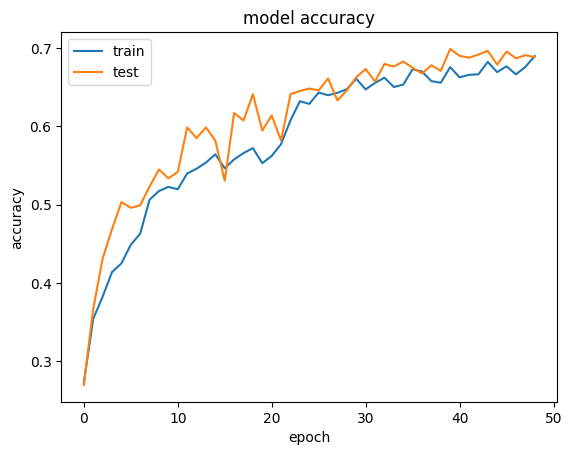

In [11]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

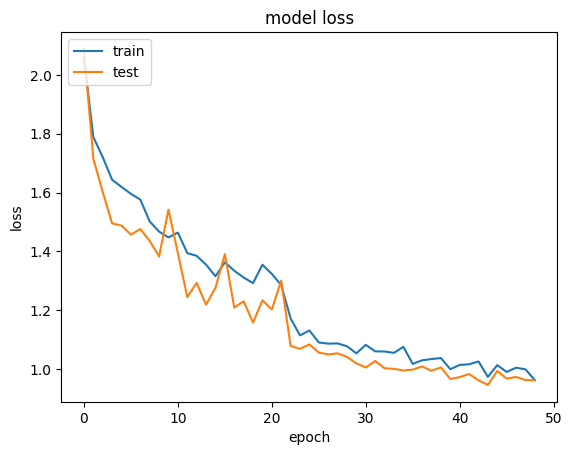

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

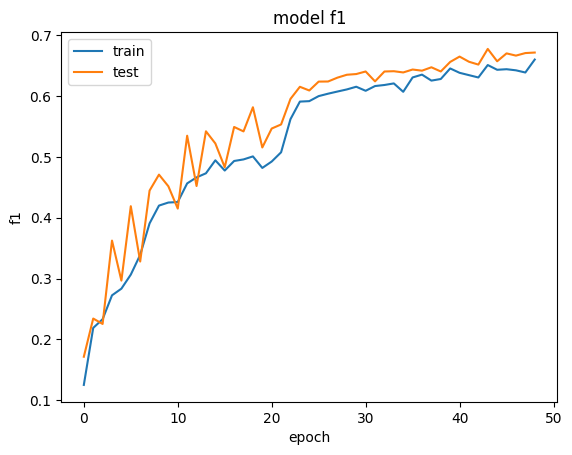

In [13]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing

In [ ]:
model.load_weights(r'E:\NU\color identification\model\model')

1/1 [==============================] - 0s 18ms/step
Predicted Color: black


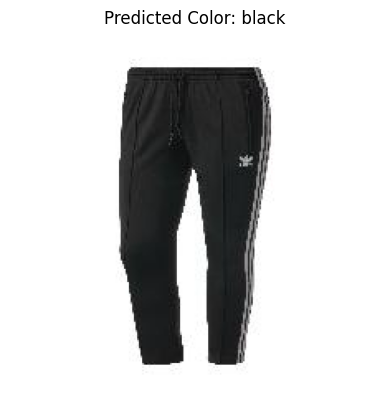

In [31]:
sample_image_path = r'E:\NU\color identification\testing'
index = 15 # Replace with the desired index

# Construct the full path of the image using the provided index
image_filename = f"{index}.jpg"  # Change the filename format as needed
full_image_path = os.path.join(sample_image_path, image_filename)
sample_image = cv2.imread(full_image_path)
sample_image1 = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image1 = cv2.resize(sample_image1, (64, 64))
sample_image1 = sample_image1 / 255.0

sample_image1 = np.reshape(sample_image1, (1, 64, 64, 3))

# Make a prediction
prediction = model.predict(sample_image1)
predicted_label = np.argmax(prediction)
predicted_color = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

print("Predicted Color:", predicted_color)
plt.imshow(sample_image)
plt.title(f"Predicted Color: {predicted_color}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 18ms/step
Predicted Color: green


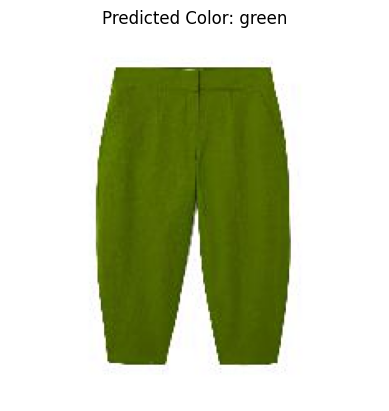

In [36]:
index = 5 # Replace with the desired index

# Construct the full path of the image using the provided index
image_filename = f"{index}.jpg"  # Change the filename format as needed
full_image_path = os.path.join(sample_image_path, image_filename)
sample_image = cv2.imread(full_image_path)
sample_image1 = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image1 = cv2.resize(sample_image1, (64, 64))
sample_image1 = sample_image1 / 255.0

sample_image1 = np.reshape(sample_image1, (1, 64, 64, 3))

# Make a prediction
prediction = model.predict(sample_image1)
predicted_label = np.argmax(prediction)
predicted_color = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

print("Predicted Color:", predicted_color)
plt.imshow(sample_image)
plt.title(f"Predicted Color: {predicted_color}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 19ms/step
Predicted Color: purple


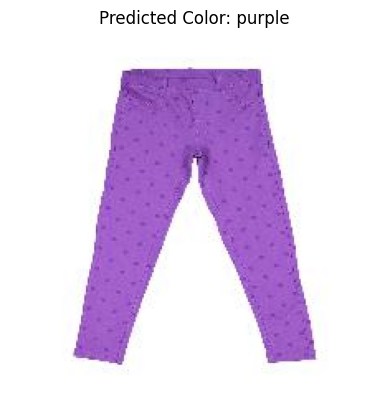

In [35]:
index = 2 # Replace with the desired index

# Construct the full path of the image using the provided index
image_filename = f"{index}.jpg"  # Change the filename format as needed
full_image_path = os.path.join(sample_image_path, image_filename)
sample_image = cv2.imread(full_image_path)
sample_image1 = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image1 = cv2.resize(sample_image1, (64, 64))
sample_image1 = sample_image1 / 255.0

sample_image1 = np.reshape(sample_image1, (1, 64, 64, 3))

# Make a prediction
prediction = model.predict(sample_image1)
predicted_label = np.argmax(prediction)
predicted_color = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

print("Predicted Color:", predicted_color)
plt.imshow(sample_image)
plt.title(f"Predicted Color: {predicted_color}")
plt.axis('off')
plt.show()